# ABC analysis for Inventory Management

In a warehouse it is important to plan the movement of goods in such a way that most critical and important items are picked and dispatched quickly. To understand which items in the inventory are important, generally ABC Segmentation of the inventory is done.

#### What is ABC Inventory Segmentation?

ABC Segmentation is part of Inventory Management process. This segmentation is used to identify items that generate the most value (like, revenue) and categorize them into critical, important and moderate. As per the basic principal of ABC Segmentation;

1.	A: are the items that are critical, high value and fast moving. 
    
    a.	20% of items generate 80% revenue.
    

2.	B: are the items that are important but have lower volume.
    
    a.	30% of items generate 15% revenue.


3.	C: are moderate and slow moving items.  
    
    a.	50% of items generate 5% revenue


In [1]:
# import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import chardet

import warnings
warnings.filterwarnings("ignore")

In [2]:
#check encoding for file
with open('online_retail.csv','rb') as raw:
    result = chardet.detect(raw.read(50000))
print("The encoding details for Loans file is : ",result)

The encoding details for Loans file is :  {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [3]:
# read the file
retail_data = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# Select features that could be made available to warhouse operations.
warehouse = retail_data[["StockCode", "Description", "Quantity", "UnitPrice", "Country"]]
warehouse.head()

,StockCode,Description,Quantity,UnitPrice,Country
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom
1,71053,WHITE METAL LANTERN,6,3.39,United Kingdom
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom


In [5]:
# Check for missing values
warehouse.isnull().sum()

StockCode         0
Description    1454
Quantity          0
UnitPrice         0
Country           0
dtype: int64

In [6]:
# removing records where quntity is 0 or -ve
warehouse = warehouse[warehouse["Quantity"] > 0]

In [7]:
# removing records where unit price is 0 or -ve
warehouse = warehouse[warehouse["UnitPrice"] > 0]

In [8]:
# Calulate the revenue (value) generated by each line item.
warehouse["Value"] = round(warehouse["Quantity"]*warehouse["UnitPrice"],2)
warehouse.head()

,StockCode,Description,Quantity,UnitPrice,Country,Value
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
1,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


In [9]:
warehouse.shape

(530104, 6)

In [10]:
# Check the structure of dataframe
warehouse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 6 columns):
StockCode      530104 non-null object
Description    530104 non-null object
Quantity       530104 non-null int64
UnitPrice      530104 non-null float64
Country        530104 non-null object
Value          530104 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 28.3+ MB


In [12]:
# Find the number of transactions done for each Stock Code

transactions = warehouse["StockCode"].value_counts()
transactions = pd.DataFrame(transactions).reset_index()
transactions.columns = ["StockCode","Transactions"]
transactions.head()

,StockCode,Transactions
0,85123A,2265
1,85099B,2112
2,22423,2017
3,47566,1706
4,20725,1595


In [13]:
# Find the total revenue generated by each stock code

warehouse_agg = warehouse.groupby(["StockCode"])["Value"].sum()
warehouse_agg = pd.DataFrame(warehouse_agg).reset_index()

In [14]:
# Combine the number of transactions and total revenue generated for each Stock Code 

warehouse_agg = pd.merge(warehouse_agg, transactions, on="StockCode", how="inner")
warehouse_agg.head()

,StockCode,Value,Transactions
0,10002,759.89,71
1,10080,119.09,22
2,10120,40.53,30
3,10123C,3.25,3
4,10124A,6.72,5


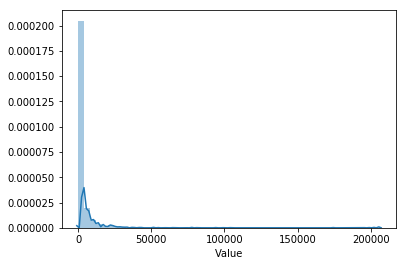

In [15]:
# Value Distribution

sns.distplot(warehouse_agg["Value"])
plt.show()

We can see from above distribution plot, very few items generate revenue more than 50,000.

In [16]:
# Stansrdaing the features used for Segmentation

scaler = StandardScaler()

warehouse_scaled = scaler.fit_transform(warehouse_agg[["Value","Transactions"]])

warehouse_scaled = pd.DataFrame(warehouse_scaled)
warehouse_scaled.columns = ["Value","Transactions"]

warehouse_scaled.head()

,Value,Transactions
0,-0.245624,-0.324301
1,-0.325935,-0.571969
2,-0.335781,-0.531533
3,-0.340454,-0.668003
4,-0.340019,-0.657894


In [17]:
# As its a ABS Segmentation, the number of clusters is 3
cluster = KMeans(n_clusters=3, random_state=100)

cluster.fit(warehouse_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

In [18]:
# Check the Segment Labels generated by K-Mean
cluster.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
# Assign the Segment Lables to each Stock Code

warehouse_agg["Segment"] = cluster.labels_
warehouse_agg.head()

,StockCode,Value,Transactions,Segment
0,10002,759.89,71,0
1,10080,119.09,22,0
2,10120,40.53,30,0
3,10123C,3.25,3,0
4,10124A,6.72,5,0


In [20]:
# Check stocks in Segment 0
warehouse_agg[warehouse_agg["Segment"] == 0]

,StockCode,Value,Transactions,Segment
0,10002,759.89,71,0
1,10080,119.09,22,0
2,10120,40.53,30,0
3,10123C,3.25,3,0
4,10124A,6.72,5,0
5,10124G,7.14,4,0
6,10125,994.84,94,0
7,10133,1544.22,198,0
8,10135,2207.39,179,0
9,11001,2389.44,115,0


In [21]:
# Check stocks in Segment 1
warehouse_agg[warehouse_agg["Segment"] == 1]

,StockCode,Value,Transactions,Segment
1006,22086,64952.29,1200,1
1310,22423,174484.74,2017,1
1942,23084,66964.99,1036,1
2020,23166,81700.92,250,1
2465,23843,168469.60,1,1
2670,47566,99504.33,1706,1
3194,84879,59094.93,1489,1
3387,85099B,94340.05,2112,1
3407,85123A,104518.80,2265,1
3911,DOT,206248.77,706,1


In [22]:
# Check stocks in Segment 2
warehouse_agg[warehouse_agg["Segment"] == 2]

,StockCode,Value,Transactions,Segment
12,15036,18569.84,519,2
18,15056BL,15828.84,321,2
19,15056N,22176.49,460,2
144,20676,6441.06,456,2
147,20679,10021.42,327,2
151,20685,28082.54,699,2
166,20711,11014.62,524,2
167,20712,22092.42,869,2
168,20713,23030.96,667,2
170,20717,3564.48,418,2


In [23]:
# Revenue% generated by segment 0
round((warehouse_agg[warehouse_agg["Segment"] == 0]["Value"].sum()/warehouse_agg["Value"].sum()) * 100)

38.0

In [24]:
# Revenue% generated by segment 1
round((warehouse_agg[warehouse_agg["Segment"] == 1]["Value"].sum()/warehouse_agg["Value"].sum()) * 100)

12.0

In [25]:
# Revenue% generated by segment 2
round((warehouse_agg[warehouse_agg["Segment"] == 2]["Value"].sum()/warehouse_agg["Value"].sum()) * 100)

50.0

In [32]:
# % of items in segment 0
round((warehouse_agg[warehouse_agg["Segment"] == 0].shape[0]/warehouse_agg.shape[0])*100,2)

89.52

In [31]:
# % of items in segment 1
round((warehouse_agg[warehouse_agg["Segment"] == 1].shape[0]/warehouse_agg.shape[0])*100,2)

0.31

In [30]:
# % of items in segment 2
round((warehouse_agg[warehouse_agg["Segment"] == 2].shape[0]/warehouse_agg.shape[0])*100,2)

10.17

In [40]:
# Map Segment Lables to ABC code

map = {2:"A", 0:"B", 1:"C"}

warehouse_agg["Segment"] = warehouse_agg["Segment"].apply(lambda x: map[x])

warehouse_agg.head()

,StockCode,Value,Transactions,Segment
0,10002,759.89,71,B
1,10080,119.09,22,B
2,10120,40.53,30,B
3,10123C,3.25,3,B
4,10124A,6.72,5,B


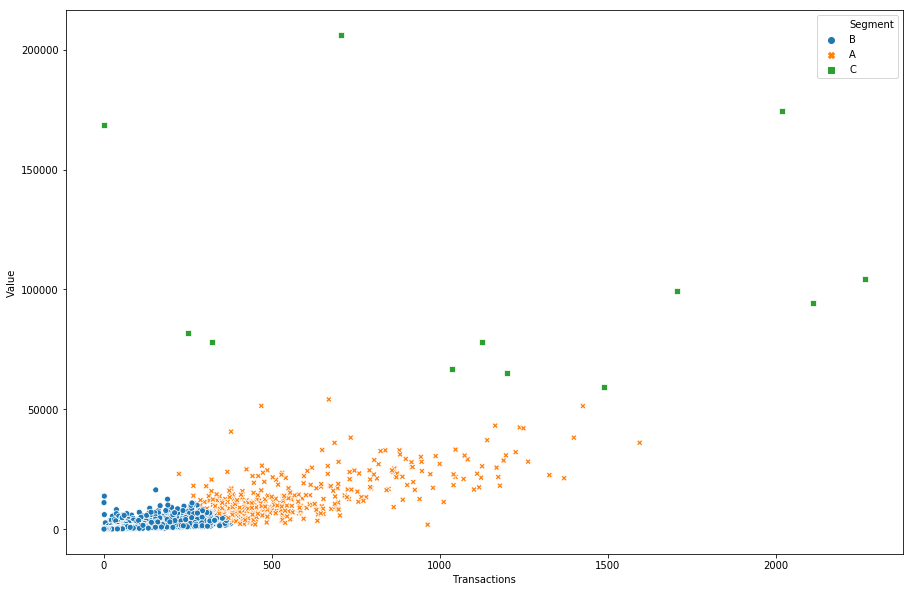

In [41]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="Transactions", y="Value", hue="Segment", style="Segment", data=warehouse_agg)
plt.show()

50% revenue is generated by 10.17% of items in segment A

38% revenue is generated by 89.52% of items in segment B

12% revenue is generated by 00.31% of items in segment C